In [110]:
%matplotlib inline

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Import packages
import xarray as xr
import xesmf as xe
import intake
import util 
import pprint 
import matplotlib.pyplot as plt
import numpy as np
from datetime import date, timedelta
import pandas as pd


## Plot annual average snow at a point under SSP-585

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 6 group(s)
ScenarioMIP.BCC.BCC-CSM2-MR.ssp585.LImon.gn
ScenarioMIP.CCCma.CanESM5.ssp585.LImon.gn
ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.LImon.gr
ScenarioMIP.MIROC.MIROC6.ssp585.LImon.gn
ScenarioMIP.MRI.MRI-ESM2-0.ssp585.LImon.gn
ScenarioMIP.NCAR.CESM2.ssp585.LImon.gn


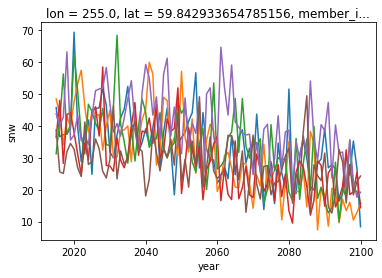

In [111]:
var = 'snw'
tgt_lat = 60
tgt_lon = 254.73 # Units in degrees east, Boulder 105.27 degrees west

# Querry data catalog
col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
cat = col.search(experiment_id=['ssp585'], variable_id=[var], member_id=['r1i1p1f1'])
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True})

# Plot
for name, ds in dset_dict.items():
    print(name)
    point_aa_snow = ds[var].sel(lon=tgt_lon, lat=tgt_lat, method='nearest').groupby('time.year').mean('time').squeeze()
    point_aa_snow.plot()

## Plot Antarctic Snowfall Under SSP-585

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 9 group(s)


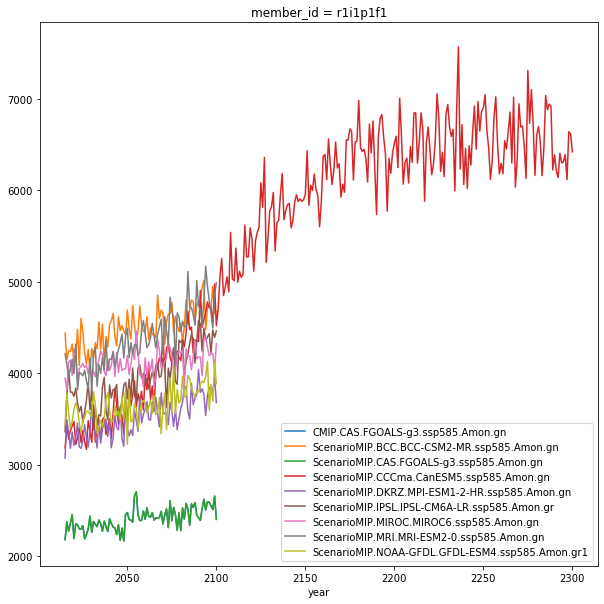

In [117]:
var = 'prsn' # Snow
lat_bound = -70 # Everything south of -70 degrees
ea = 510.1e12 # earth area in meters^2

# Querry data catalog
col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
cat = col.search(experiment_id=['ssp585'], variable_id=[var], member_id=['r1i1p1f1'])
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True}, cdf_kwargs={'chunks': {'time': 1000}})

# Plot
plt.figure(figsize=(10,10))
for name, ds in dset_dict.items():
    weights = np.cos(np.deg2rad(ds[var]['lat'])) * xr.ones_like(ds[var]['lon'])    
    weights_sum = weights.sum(dim=['lat','lon'])

    ant_snow = ds[var].where(ds['lat'] < lat_bound).groupby('time.year').sum('time').squeeze()
    ant_snow = ant_snow * weights / weights_sum * ea
    ant_snow = ant_snow.sum(dim='lat').sum(dim='lon') * 3.154e+7 / 12 / 1e12 # Unit conversions to Gt/yr
    ant_snow.plot(label = name)
plt.legend()
        

## Plot CESM2 global average 2 meter temperature under different emissions scenarios 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 3 group(s)
['ScenarioMIP.NCAR.CESM2.ssp126.Amon.gn', 'ScenarioMIP.NCAR.CESM2.ssp370.Amon.gn', 'ScenarioMIP.NCAR.CESM2.ssp585.Amon.gn']


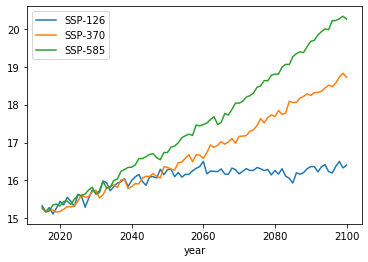

In [119]:
# Querry data catalog 
col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
cat = col.search(experiment_id=['ssp126', 'ssp370', 'ssp585'], source_id=['CESM2'], variable_id=['tas'])
ds = cat.to_dataset_dict()
print(list(ds))

# Calculate gridcell area weights
cos_lat_2d = np.cos(np.deg2rad(ds['ScenarioMIP.NCAR.CESM2.ssp126.Amon.gn']['lat'])) \
    * xr.ones_like(ds['ScenarioMIP.NCAR.CESM2.ssp126.Amon.gn']['lon']) # effective area weights

# Create xarray data arrays
ssp_126 = ds['ScenarioMIP.NCAR.CESM2.ssp126.Amon.gn']['tas'] - 273.15
ssp_370 = ds['ScenarioMIP.NCAR.CESM2.ssp370.Amon.gn']['tas'] - 273.15
ssp_585 = ds['ScenarioMIP.NCAR.CESM2.ssp585.Amon.gn']['tas'] - 273.15

# Apply area weights
ssp_126 = (ssp_126 * cos_lat_2d).sum(dim=['lat','lon']) / cos_lat_2d.sum(dim=['lat','lon'])
ssp_370 = (ssp_370 * cos_lat_2d).sum(dim=['lat','lon']) / cos_lat_2d.sum(dim=['lat','lon'])
ssp_585 = (ssp_585 * cos_lat_2d).sum(dim=['lat','lon']) / cos_lat_2d.sum(dim=['lat','lon'])

# Plot
ssp_126.groupby('time.year').mean('time').plot(label='SSP-126')
ssp_370.mean(dim='member_id').groupby('time.year').mean('time').plot(label='SSP-370')
ssp_585.mean(dim='member_id').groupby('time.year').mean('time').plot(label='SSP-585')
plt.legend()